In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
from patsy import dmatrices

In [2]:
np.random.seed(0)

# Regularization and overfitting

Today we'll dive more into building predictive models, building a case count prediction model for NYC COVID data as an example. 

In [3]:
# download NYC case count data - don't need to do this again.
#!curl https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/cases-by-day.csv > lecture_7_cases-by-day.csv

In [4]:
d = pd.read_csv('lecture_7_cases-by-day.csv')

In [5]:
d.head()

,date_of_interest,CASE_COUNT,PROBABLE_CASE_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,BX_CASE_COUNT,BX_PROBABLE_CASE_COUNT,BX_CASE_COUNT_7DAY_AVG,BX_ALL_CASE_COUNT_7DAY_AVG,BK_CASE_COUNT,...,MN_ALL_CASE_COUNT_7DAY_AVG,QN_CASE_COUNT,QN_PROBABLE_CASE_COUNT,QN_CASE_COUNT_7DAY_AVG,QN_ALL_CASE_COUNT_7DAY_AVG,SI_CASE_COUNT,SI_PROBABLE_CASE_COUNT,SI_CASE_COUNT_7DAY_AVG,SI_ALL_CASE_COUNT_7DAY_AVG,INCOMPLETE
0,02/29/2020,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,03/01/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,03/02/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,03/03/2020,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,03/04/2020,5,0,0,0,0,0,0,0,1,...,0,2,0,0,0,0,0,0,0,0


### We want to predict CASE_COUNT (defined as "Count of confirmed cases citywide") as a function of time. We'll add a new column, t, to measure the number of days since the beginning of the year. 

(small note: we make t mean zero to reduce multicollinearity when we use higher-order polynomial terms, and divide it by its largest absolute value so it doesn't get too huge; this avoids potential numerical issues). 

In [6]:
assert d['date_of_interest'].duplicated().sum() == 0
print("Number of unique dates: %i" % len(d))

d['date_of_interest'] = d['date_of_interest'].map(lambda x:datetime.datetime.strptime(x, '%m/%d/%Y'))

d['days_since_beginning_of_year'] = d['date_of_interest'].map(lambda x:(x - datetime.datetime(2020, 1, 1)).days)
d['t'] = (d['days_since_beginning_of_year'] - d['days_since_beginning_of_year'].mean())
d['t'] = d['t'] / np.abs(d['t']).max()
d = d[['date_of_interest', 't', 'CASE_COUNT', 'days_since_beginning_of_year']]
print(d.tail())

Number of unique dates: 522
    date_of_interest         t  CASE_COUNT  days_since_beginning_of_year
517       2021-07-30  0.984645        1195                           576
518       2021-07-31  0.988484         745                           577
519       2021-08-01  0.992322         729                           578
520       2021-08-02  0.996161        1357                           579
521       2021-08-03  1.000000        1206                           580


# Start by making a simple scatterplot of the data

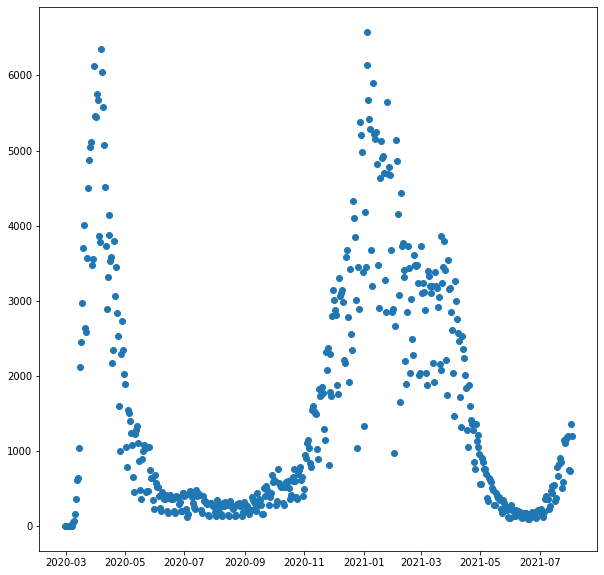

In [7]:
plt.figure(figsize=[10, 10])
plt.scatter(d['date_of_interest'], 
           d['CASE_COUNT'])

In [8]:
# we will be predicting during first wave.

first_wave = d.loc[d['date_of_interest'].map(lambda x:x <= datetime.datetime(2020, 10, 1))].copy()

# Divide data randomly into train and test set. 

We use the train set to fit the model, test set to assess how well it does on data that wasn't used to fit it. We'll see why this matters in a second...

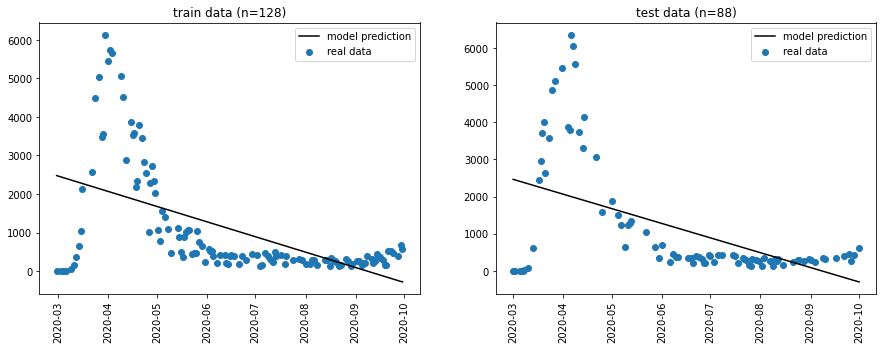

In [9]:
first_wave['dataset'] = ['train' if np.random.random() < 0.6 else 'test' for i in range(len(first_wave))]

formula = 'CASE_COUNT ~ t'

def compute_performance_metrics(y, prediction):
    # first have to define some performance metrics. 
    return {'rmse':np.sqrt(np.mean((y - prediction) ** 2)), 
            'mae':np.mean(np.abs(y - prediction)),
            'R^2':pearsonr(y, prediction)[0] ** 2}

def assess_OLS_fitting_performance(d, formula, display_performance=False):
    d = d.copy()
    d = d.sort_values(by='t') # makes plotting easier. 
    
    # fit on train set
    model = sm.OLS.from_formula(formula, d.loc[d['dataset'] == 'train']).fit()
    d['prediction'] = model.predict(d)
        
    plt.figure(figsize=[15, 5])
    subplot_idx = 1
    
    # make separate plots of performance on train and test set
    for k in ['train', 'test']:
        plt.subplot(1, 2, subplot_idx)
        
        # real data
        plt.scatter(d.loc[d['dataset'] == k, 'date_of_interest'], 
                    d.loc[d['dataset'] == k, 'CASE_COUNT'], 
                    label='real data')
        
        # prediction
        plt.plot(d.loc[d['dataset'] == k, 'date_of_interest'], 
                 d.loc[d['dataset'] == k, 'prediction'], 
                 color='black', 
                 label='model prediction')                                
        plt.legend()
        
        title_string = k + ' data (n=%i)' % (d['dataset'] == k).sum()
        if display_performance:
            performance = compute_performance_metrics(y=d.loc[d['dataset'] == k, 'CASE_COUNT'].values,
                                                  prediction=d.loc[d['dataset'] == k, 'prediction'].values)
            for metric in performance:
                title_string = title_string + '\n%s: %2.3f' % (metric, performance[metric])
        plt.title(title_string)
        plt.xticks(rotation=90)
        subplot_idx += 1
    
    
    
    
    
    
assess_OLS_fitting_performance(first_wave, formula)

## Great! We'll have negative COVID cases by August 2020...

obviously, this linear model fit is terrible. So we can try fitting a fancier model with higher polynomial terms...

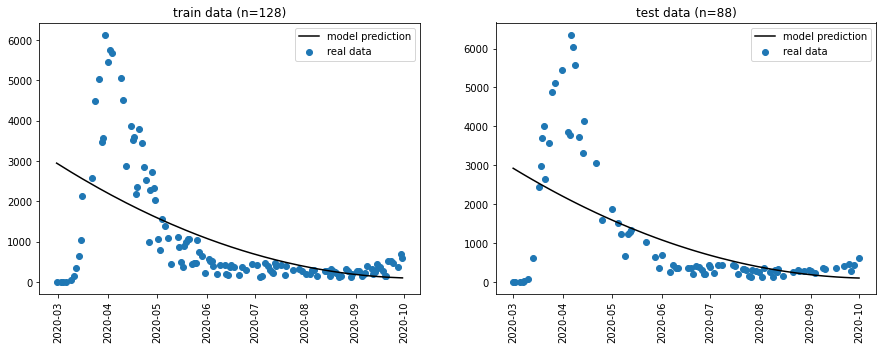

In [10]:
assess_OLS_fitting_performance(first_wave, formula='CASE_COUNT ~ I(t) + I(t ** 2)')

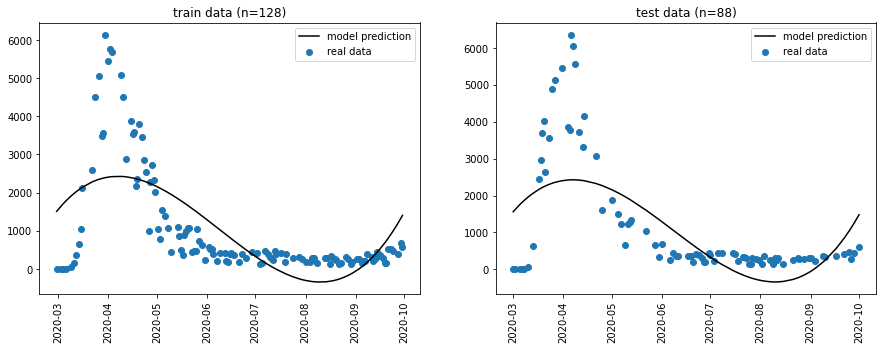

In [11]:
assess_OLS_fitting_performance(first_wave, formula='CASE_COUNT ~ I(t) + I(t ** 2) + I(t ** 3)')

## (Incidentally, you can already see some inherent limitations of some of these model forms: for example, they can predict case counts below zero. We'll ignore this for now, but in the real world, people use other models, like Poisson or Negative Binomial, to avoid having negative case counts. What's another important problem with fitting a cubic model? You might think that no one would be silly enough to do this in the real world, but, nope, they are - https://www.vox.com/2020/5/8/21250641/kevin-hassett-cubic-model-smoothing). 

Our fit seems to be getting better! Let's add a TON OF TERMS TO BUILD THE PERFECT PREDICTION MODEL~!!!!!!!!!!!!!!!!!!!! ! !! ! 111!!

In [12]:
SUPER_BIG_FORMULA_TO_END_ALL_FORMULAS = 'CASE_COUNT ~ I(t)'

for i in range(2, 200):
    SUPER_BIG_FORMULA_TO_END_ALL_FORMULAS = SUPER_BIG_FORMULA_TO_END_ALL_FORMULAS + '+ I(t ** %i)' % i
print(SUPER_BIG_FORMULA_TO_END_ALL_FORMULAS)




CASE_COUNT ~ I(t)+ I(t ** 2)+ I(t ** 3)+ I(t ** 4)+ I(t ** 5)+ I(t ** 6)+ I(t ** 7)+ I(t ** 8)+ I(t ** 9)+ I(t ** 10)+ I(t ** 11)+ I(t ** 12)+ I(t ** 13)+ I(t ** 14)+ I(t ** 15)+ I(t ** 16)+ I(t ** 17)+ I(t ** 18)+ I(t ** 19)+ I(t ** 20)+ I(t ** 21)+ I(t ** 22)+ I(t ** 23)+ I(t ** 24)+ I(t ** 25)+ I(t ** 26)+ I(t ** 27)+ I(t ** 28)+ I(t ** 29)+ I(t ** 30)+ I(t ** 31)+ I(t ** 32)+ I(t ** 33)+ I(t ** 34)+ I(t ** 35)+ I(t ** 36)+ I(t ** 37)+ I(t ** 38)+ I(t ** 39)+ I(t ** 40)+ I(t ** 41)+ I(t ** 42)+ I(t ** 43)+ I(t ** 44)+ I(t ** 45)+ I(t ** 46)+ I(t ** 47)+ I(t ** 48)+ I(t ** 49)+ I(t ** 50)+ I(t ** 51)+ I(t ** 52)+ I(t ** 53)+ I(t ** 54)+ I(t ** 55)+ I(t ** 56)+ I(t ** 57)+ I(t ** 58)+ I(t ** 59)+ I(t ** 60)+ I(t ** 61)+ I(t ** 62)+ I(t ** 63)+ I(t ** 64)+ I(t ** 65)+ I(t ** 66)+ I(t ** 67)+ I(t ** 68)+ I(t ** 69)+ I(t ** 70)+ I(t ** 71)+ I(t ** 72)+ I(t ** 73)+ I(t ** 74)+ I(t ** 75)+ I(t ** 76)+ I(t ** 77)+ I(t ** 78)+ I(t ** 79)+ I(t ** 80)+ I(t ** 81)+ I(t ** 82)+ I(t ** 83)+ I(t *

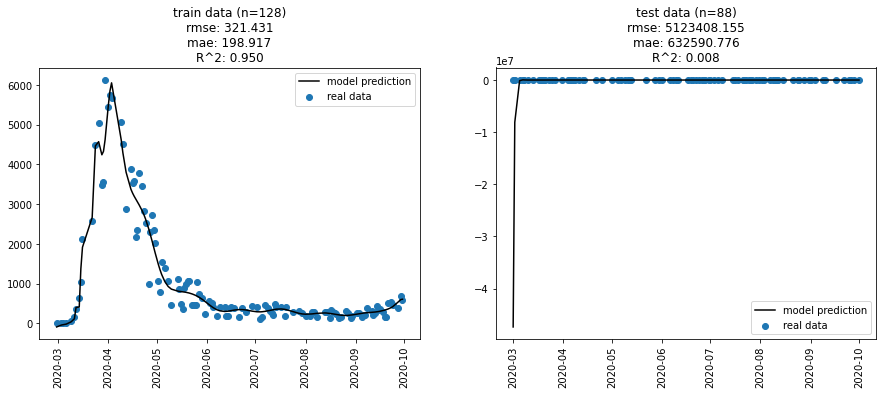

In [13]:
assess_OLS_fitting_performance(first_wave, 
    formula=SUPER_BIG_FORMULA_TO_END_ALL_FORMULAS, 
                               display_performance=True)
                               

## Something went pretty wrong there. One possibility would be that you really shouldn't fit polynomials that high-order for simple numerical reasons alone...we could try fitting sinusoids instead. 

If you've ever seen Fourier series, this may remind you of that. https://peerj.com/preprints/3190.pdf provides more details. 

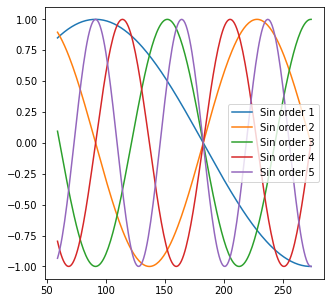

In [14]:
n_sinusoids = 100
for i in range(1, n_sinusoids):
    first_wave['sin_order_%i' % i] = np.sin(first_wave['days_since_beginning_of_year'] * i * 2 * np.pi / 365.)
    first_wave['cos_order_%i' % i] = np.cos(first_wave['days_since_beginning_of_year'] * i * 2 * np.pi / 365.)
    
    
plt.figure(figsize=[5, 5])

for i in range(1, 6):
    plt.plot(first_wave['days_since_beginning_of_year'], 
            first_wave['sin_order_%i' % i], label='Sin order %i' % i)
plt.legend()
plt.show()


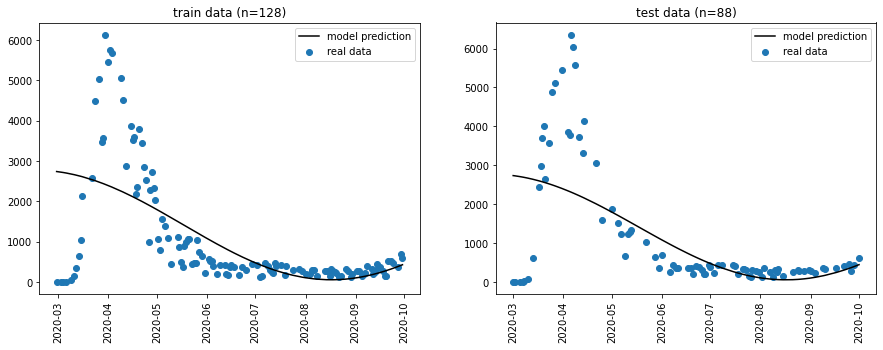

In [15]:
assess_OLS_fitting_performance(first_wave, 
    formula='CASE_COUNT ~ sin_order_1 + cos_order_1')

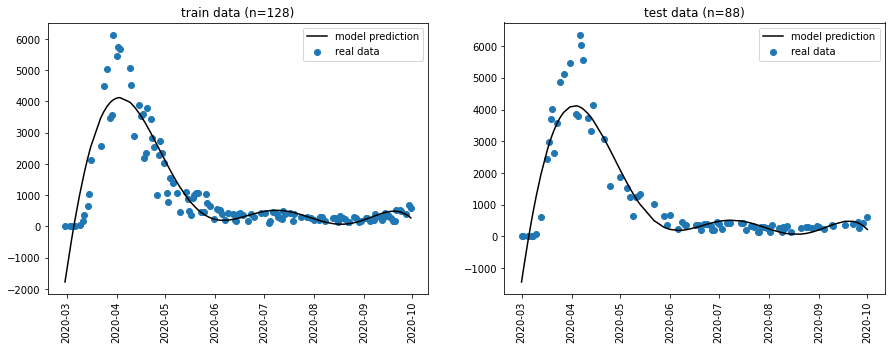

In [16]:
assess_OLS_fitting_performance(first_wave, 
    formula='CASE_COUNT ~ sin_order_1 + cos_order_1 + sin_order_2 + cos_order_2 + sin_order_3 + cos_order_3')
                          

# As before, using more terms is improving model fit, so let's try using a ton of terms. 

In [17]:
SUPER_BIG_FORMULA_SIN_FORMULA = 'CASE_COUNT ~'

for i in range(1, 90):
    SUPER_BIG_FORMULA_SIN_FORMULA = SUPER_BIG_FORMULA_SIN_FORMULA + ' + sin_order_%i + cos_order_%i' % (i, i)
print(SUPER_BIG_FORMULA_SIN_FORMULA)




CASE_COUNT ~ + sin_order_1 + cos_order_1 + sin_order_2 + cos_order_2 + sin_order_3 + cos_order_3 + sin_order_4 + cos_order_4 + sin_order_5 + cos_order_5 + sin_order_6 + cos_order_6 + sin_order_7 + cos_order_7 + sin_order_8 + cos_order_8 + sin_order_9 + cos_order_9 + sin_order_10 + cos_order_10 + sin_order_11 + cos_order_11 + sin_order_12 + cos_order_12 + sin_order_13 + cos_order_13 + sin_order_14 + cos_order_14 + sin_order_15 + cos_order_15 + sin_order_16 + cos_order_16 + sin_order_17 + cos_order_17 + sin_order_18 + cos_order_18 + sin_order_19 + cos_order_19 + sin_order_20 + cos_order_20 + sin_order_21 + cos_order_21 + sin_order_22 + cos_order_22 + sin_order_23 + cos_order_23 + sin_order_24 + cos_order_24 + sin_order_25 + cos_order_25 + sin_order_26 + cos_order_26 + sin_order_27 + cos_order_27 + sin_order_28 + cos_order_28 + sin_order_29 + cos_order_29 + sin_order_30 + cos_order_30 + sin_order_31 + cos_order_31 + sin_order_32 + cos_order_32 + sin_order_33 + cos_order_33 + sin_order_34 

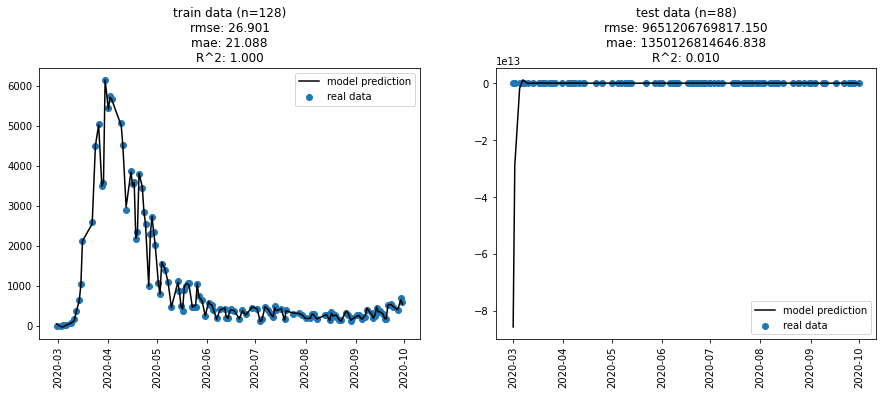

In [18]:
assess_OLS_fitting_performance(first_wave, formula=SUPER_BIG_FORMULA_SIN_FORMULA, display_performance=True)

## Something more fundamental is happening here. It's not just about using polynomials vs sinusoids. It's that we're *overfitting* to noise in the train dataset. Our super duper wiggly model (yes, that's the correct technical term) looks awesome on the train set, but it doesn't generalize to new data. 

One standard way to deal with this is to divide the data not into two, but three sets: a train set, a validation set, and a test set. 

**Train set**: This is the data you use to fit the models. 

**Validation set**: This is the data you use to choose the model which performs best on new data. It is sometimes called the dev or development set. This gives you a more realistic view of how your model actually performs on real data. 

**Test set**: This is the data you use to assess performance of the best validation model. You are really only supposed to assess your results ONCE on the test set. 

Note that there are two tasks we're trying to perform here - 1) *model selection*: given a set of models, we're trying to choose the best one (how wiggly should we allow the model to be?) and 2) *model assessment*: how well does that model actually perform? We use the validation set for the first task, and the test set for the second. 

Let's modify our function above to accomodate a validation set.

Notice that the function signature below looks slightly different: 

1. I've introduced something called "model_hyperparameters". "Hyperparameters" specify the model we want to fit - for example, they might include the linear regression formula we want to use, and how many terms it has. 
2. The function now also requires a validation set. 

In [19]:
def train_test_or_val():
    rand_number = np.random.random() 
    if rand_number < 0.6:
        return 'train'
    elif rand_number < 0.8:
        return 'val'
    else:
        return 'test'
first_wave['dataset'] = [train_test_or_val() for a in range(len(first_wave))]

def assess_with_validation_set(d, model_hyperparameters, make_plot=False):
    d = d.copy()
    d = d.sort_values(by='t')
    
    # this code is new. 
    if model_hyperparameters['model_type'] == 'OLS':
        model = sm.OLS.from_formula(model_hyperparameters['OLS_formula'], d.loc[d['dataset'] == 'train']).fit()
    d['prediction'] = model.predict(d)    
    performance_on_all_datasets = {}
    for dataset in ['train', 'val', 'test']:
        performance = compute_performance_metrics(y=d.loc[d['dataset'] == dataset, 'CASE_COUNT'].values,
                                                  prediction=d.loc[d['dataset'] == dataset, 'prediction'].values)
        for metric in performance:
            performance_on_all_datasets['%s_%s' % (metric, dataset)] = performance[metric]
        
    # this code is the same as before. 
    if make_plot:
        plt.figure(figsize=[20, 5])
        subplot_idx = 1
        # similar code to before in case we want to make plots. 
        for k in ['train', 'val', 'test']:
            plt.subplot(1, 3, subplot_idx)
            plt.scatter(d.loc[d['dataset'] == k, 'date_of_interest'], 
                        d.loc[d['dataset'] == k, 'CASE_COUNT'], 
                        label='real data')
            plt.plot(d.loc[d['dataset'] == k, 'date_of_interest'], 
                     d.loc[d['dataset'] == k, 'prediction'], 
                     color='black', 
                     label='model prediction')

            plt.legend()

            title_string = k + ' data (n=%i)' % (d['dataset'] == k).sum()
            performance = compute_performance_metrics(y=d.loc[d['dataset'] == k, 'CASE_COUNT'].values,
                                prediction=d.loc[d['dataset'] == k, 'prediction'].values)
            for metric in performance:
                title_string = title_string + '\n%s: %2.3f' % (metric, performance[metric])
            plt.title(title_string)
            plt.xticks(rotation=90)
            subplot_idx += 1
    return performance_on_all_datasets


    
assess_with_validation_set(first_wave, model_hyperparameters={'model_type':'OLS', 
                                                             'OLS_formula':'CASE_COUNT ~ sin_order_1 + cos_order_1'})

{'rmse_train': 1144.5413227464167,
 'mae_train': 707.1587198161678,
 'R^2_train': 0.4805038596465763,
 'rmse_val': 1200.3424892502533,
 'mae_val': 700.2727884344351,
 'R^2_val': 0.276837798279869,
 'rmse_test': 1222.5027193716057,
 'mae_test': 783.2607305688696,
 'R^2_test': 0.32024564112043935}

# Let's systematically see how model performance changes as we add more terms. 

In [20]:

all_results = []

for n_terms in range(1, 30):
    print(n_terms)
    formula_to_use = 'CASE_COUNT ~ sin_order_1 + cos_order_1'
    for i in range(1, n_terms + 1):
        formula_to_use = formula_to_use + ' + sin_order_%i + cos_order_%i' % (i, i)
    results = assess_with_validation_set(first_wave, model_hyperparameters={'model_type':'OLS', 
                                                             'OLS_formula':formula_to_use})
    results['n_sinusoids'] = n_terms
    all_results.append(results)
all_results = pd.DataFrame(all_results)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


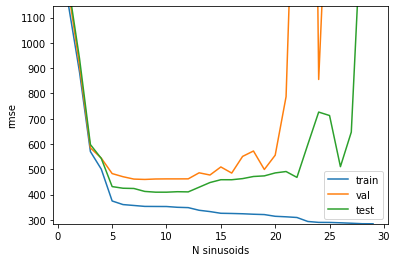

In [21]:
metric = 'rmse'

for dataset in ['train', 'val', 'test']:
    plt.plot(all_results['n_sinusoids'], all_results['%s_%s' % (metric, dataset)], label=dataset)
plt.xlabel("N sinusoids")
plt.ylim([all_results['%s_train' % metric].min() - 0.1, all_results['%s_train' % metric].max() + 0.1])
plt.ylabel("%s" % metric)
plt.legend()


# To select the model with the number of sinusoids which yields the best generalization performance, we could use the val set. 


In [22]:
best_n_sinusoids = int(all_results.sort_values(by='rmse_val').iloc[0]['n_sinusoids'])
best_n_sinusoids

8

{'rmse_train': 353.48936386824334,
 'mae_train': 212.97893233803475,
 'R^2_train': 0.9504467580681739,
 'rmse_val': 460.1002353169928,
 'mae_val': 250.93496242860726,
 'R^2_val': 0.8951223085202481,
 'rmse_test': 412.69637341489477,
 'mae_test': 260.2299949116049,
 'R^2_test': 0.9170757863562247}

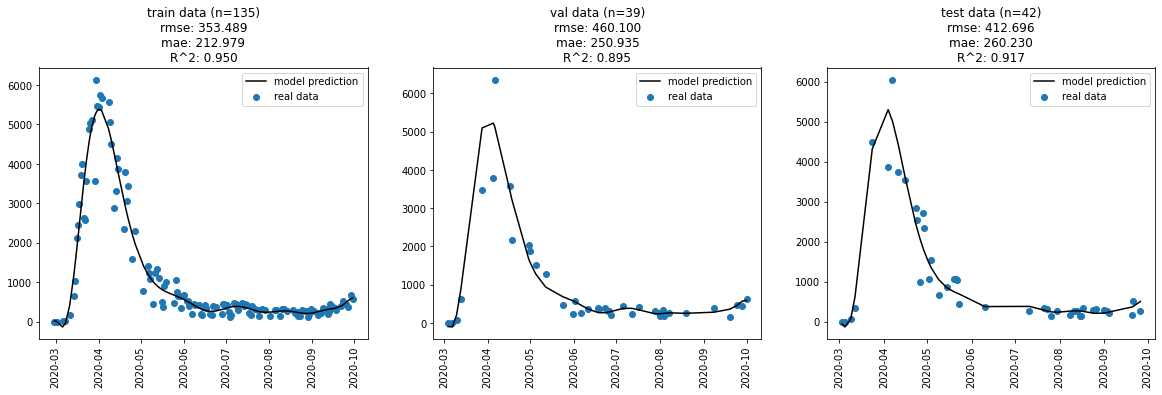

In [23]:
formula_to_use = 'CASE_COUNT ~ sin_order_1 + cos_order_1'
for i in range(1, best_n_sinusoids + 1):
    formula_to_use = formula_to_use + ' + sin_order_%i + cos_order_%i' % (i, i)
        
assess_with_validation_set(first_wave, model_hyperparameters={'model_type':'OLS', 
                                                             'OLS_formula':formula_to_use}, 
                           make_plot=True)

# Regularization and overfitting day 2

It's possible we'll end slightly early today because we have less material, but I don't want to start on the causality lecture early because the material is quite different, so if we have extra time we'll just spend a little while discussing people's project proposals. 

# Regularization

Another approach to preventing overfitting is called "regularization". Regularization penalizes the model for adding additional terms, encouraging it not to add additional terms unless they really improve model fit and guiding us towards simple models which are more likely to generalize. Recall from last lecture that in standard linear regression (with no regularization) we minimize the sum of squared errors, SSE. (We sometimes call the thing we want to minimize the "loss"):

$$loss_{\text{linear regression}} = SSE = \sum_i \bigg(\alpha + \sum_j \beta_j X_{ij} - y_i\bigg) ^2$$

This looks a little mathy, but it's just what we saw before - linear regression chooses an intercept $\alpha$ and feature weights $\beta$ which minimize the sum of squared errors. ($i$ sums over all datapoints, and $j$ sums over each of the multiple regression features). 

When we regularize, we add a penalty term to this which penalizes the model for having big $\beta$. This encourages the model to keep the $\beta$ as small as possible, reducing the complexity of the model. So we choose the model which minimizes

$$SSE + penalty(\beta)$$

For example, in *lasso* regression, the penalty is the sum of the absolute values of the entries of $\beta$:

$$loss_{lasso} = SSE + \lambda \sum_j |\beta_j|$$

And in *ridge* regression, the penalty is the sum of the squared values of the entries of $\beta$:

$$loss_{ridge} = SSE + \lambda \sum_j \beta_j ^ 2$$

In both cases, $\lambda$ controls the strength of the regularization. 



A couple points: 

1. We do not generally penalize the intercept $\alpha$, because we want the model to be able to match the overall mean of the data. 
2. Because we're penalizing each beta the same way, it's important all the $X$ are on the same scale. If one $X$ is 100x as big, then the model can use a $\beta$ 100x as small, and have a much less big penalty for including that X. Because of this, we generally standardize the predictors (eg, by subtracting the mean and dividing by the standard deviation) prior to fitting the model. 
3. Packages differ in exactly how they specify the regularization strength ($\lambda$). For example, sometimes you pass in a parameter where bigger values indicate SMALLER regularization; sometimes there's a factor that accounts for the size of the dataset; etc. Always read the documentation to understand what the regularization actually does. 

That's a bit abstract. Let's see how this works in practice. We'll fit a model using the first twenty sin and cosine terms. 



In [24]:
formula_to_use = 'CASE_COUNT ~ sin_order_1 + cos_order_1'
for i in range(1, 21):
    formula_to_use = formula_to_use + ' + sin_order_%i + cos_order_%i' % (i, i)
print(formula_to_use)


CASE_COUNT ~ sin_order_1 + cos_order_1 + sin_order_1 + cos_order_1 + sin_order_2 + cos_order_2 + sin_order_3 + cos_order_3 + sin_order_4 + cos_order_4 + sin_order_5 + cos_order_5 + sin_order_6 + cos_order_6 + sin_order_7 + cos_order_7 + sin_order_8 + cos_order_8 + sin_order_9 + cos_order_9 + sin_order_10 + cos_order_10 + sin_order_11 + cos_order_11 + sin_order_12 + cos_order_12 + sin_order_13 + cos_order_13 + sin_order_14 + cos_order_14 + sin_order_15 + cos_order_15 + sin_order_16 + cos_order_16 + sin_order_17 + cos_order_17 + sin_order_18 + cos_order_18 + sin_order_19 + cos_order_19 + sin_order_20 + cos_order_20


We're doing to be using scikit-learn to fit and it wants matrices. We'll use the patsy dmatrices command to make matrices from our dataframe + formula. This is a little more complicated than we need here, since our formula is very simple and we could just select the columns, but it will be useful for the homework because you will have a complex statsmodels formula, and you'd like to get a matrix which corresponds to that formula which you can feed into sklearn for more complicated model fitting techniques. Below is an example of how to do this...

In [26]:
formula_to_use

'CASE_COUNT ~ sin_order_1 + cos_order_1 + sin_order_1 + cos_order_1 + sin_order_2 + cos_order_2 + sin_order_3 + cos_order_3 + sin_order_4 + cos_order_4 + sin_order_5 + cos_order_5 + sin_order_6 + cos_order_6 + sin_order_7 + cos_order_7 + sin_order_8 + cos_order_8 + sin_order_9 + cos_order_9 + sin_order_10 + cos_order_10 + sin_order_11 + cos_order_11 + sin_order_12 + cos_order_12 + sin_order_13 + cos_order_13 + sin_order_14 + cos_order_14 + sin_order_15 + cos_order_15 + sin_order_16 + cos_order_16 + sin_order_17 + cos_order_17 + sin_order_18 + cos_order_18 + sin_order_19 + cos_order_19 + sin_order_20 + cos_order_20'

In [33]:
Y, X = dmatrices(formula_to_use, first_wave, return_type='dataframe')
X = X[[a for a in X.columns if a != 'Intercept']] # remove intercept since sklearn adds that automatically 
# when it fits the model
X = X.values # matrix we can use for sklearn which corresponds to the formula
Y = Y.values
X.shape # 40 columns for each of the sine/cosine terms

(216, 40)

In [37]:
# divide into train test val set

train_X = X[first_wave['dataset'] == 'train', :].copy()
val_X = X[first_wave['dataset'] == 'val', :].copy()
test_X = X[first_wave['dataset'] == 'test', :].copy()

# Use standardscaler to normalize the columns of our matrix

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
print(train_X.std(axis=0))
print(train_X.mean(axis=0))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 3.51981818e-16 -6.71068139e-16 -2.25334155e-16 -1.15134240e-17
 -1.15134240e-17  7.64996991e-17  2.11764762e-17  1.71056585e-16
  8.22387426e-18  1.02233037e-16  5.64363371e-17  4.60536958e-17
 -9.86864911e-18  7.70988212e-17 -1.91205076e-17 -2.79611725e-17
 -3.45402719e-17  4.48201147e-17  6.35294286e-17 -2.30268479e-17
 -1.15134240e-17  3.78298216e-17 -4.52313084e-18  2.46716228e-17
  0.00000000e+00 -2.44660259e-17  1.54197642e-17  1.48029737e-17
  2.46716228e-17 -4.60536958e-17  1.99428951e-17 -4.44089210e-17
 -3.28954970e-18 -1.27470051e-17 -1.64477485e-18 -3.61850467e-17
 -1.15134240e-17  1.97372982e-17 -1.27470051e-17  3.78298216e-17]


In [38]:
val_X = scaler.transform(val_X) # notice we use transform, not fit_transform here. 
# this is because the scaling is part of our model pipeline, so we want to learn all parameters just on the train dataset. 
test_X = scaler.transform(test_X) # notice we use transform, not fit_transform here. 

print(val_X.std(axis=0))
print(test_X.mean(axis=0))

[0.93651824 1.04527422 0.99446129 1.02241879 1.04569963 0.95031343
 1.04952031 0.97332593 0.97978339 1.02156975 0.89034607 1.11322477
 1.01387986 0.90499055 0.98303318 0.9787817  1.11079461 0.85711493
 1.07737069 0.91789647 0.99356713 1.00570196 0.9902731  0.96692535
 1.03275418 0.92166998 1.03656047 0.95357347 1.00571329 0.97939829
 1.11032009 0.8859016  0.9928884  0.96810821 1.02115366 0.91273598
 0.97000819 0.99988645 1.04620885 0.88545616]
[ 0.02254432  0.0868505   0.0345982  -0.20956935 -0.17882063  0.44359468
  0.35043479 -0.48845459 -0.25359376  0.15410873 -0.13675605  0.10306238
  0.2613353   0.00476695  0.05350777 -0.03677936 -0.14178864 -0.09702584
 -0.04756823 -0.02811487  0.05971963  0.14465507 -0.10986707  0.03873816
  0.24713192  0.04179089 -0.02376216 -0.36694145 -0.24015679  0.20757548
  0.06094896  0.24702113  0.04512011 -0.47873952  0.10185297  0.41512251
 -0.05599595 -0.02047468 -0.05299253 -0.46127482]


In [39]:
# Now we have processed data! We are ready to fit a model. Let's start by fitting a ridge regression model. 
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(train_X, Y[first_wave['dataset'] == 'train'])

# print out coefficients (beta)
print(ridge_model.coef_)

[[ 4.70229740e+02  2.31820619e+02 -3.05164000e+02 -4.18493572e+02
  -4.23958907e+02  1.75634283e+02  2.67271164e+02  4.12794647e+02
   3.70936938e+02 -9.38763082e+01 -8.11961275e+01 -3.28821818e+02
  -2.53410480e+02 -5.28495597e+01 -2.80335000e+01  1.58460593e+02
   6.35185278e+01  8.41159197e+01  2.04387126e+01 -3.31304791e+00
  -3.10502052e+00 -2.84706981e+01  4.59121526e+01  3.66492675e-01
   6.13762970e+01  6.30820775e+00 -1.56350316e+01 -5.82735261e+01
  -8.82368265e+01 -7.42398996e+01 -7.27600799e+01 -1.37292078e+01
  -8.10387028e+00  8.52513683e+01 -3.18621112e+01  1.67708004e+02
  -3.19320416e+01  2.26911751e+02  3.08169795e+01  1.38165700e+02]]


In [40]:
# print out train predictions
print(ridge_model.predict(train_X))

[[  86.68605083]
 [  87.04361994]
 [  48.24671527]
 [-221.02552068]
 [-193.90288468]
 [ 282.64227709]
 [1205.98503834]
 [1560.63484732]
 [1916.38522732]
 [2261.97194951]
 [2589.03642864]
 [2892.65567298]
 [3171.40650987]
 [3426.98049986]
 [3663.41924975]
 [3886.08319351]
 [4311.2141259 ]
 [4520.87610068]
 [4729.53618039]
 [5129.84660282]
 [5308.14438112]
 [5460.09402668]
 [5576.19592634]
 [5647.78998779]
 [5668.16650691]
 [4992.73047991]
 [4748.31983926]
 [4494.52109971]
 [4009.39833644]
 [3798.72709626]
 [3618.12529143]
 [3469.6580119 ]
 [3117.45533356]
 [3049.24863409]
 [2970.2294881 ]
 [2872.88564955]
 [2437.20516749]
 [2048.31793614]
 [1087.16430021]
 [ 990.26862078]
 [1003.42643429]
 [1026.69250917]
 [1070.79801139]
 [1077.84063526]
 [1041.86479913]
 [ 997.9383582 ]
 [ 872.56862837]
 [ 801.58546361]
 [ 733.08783234]
 [ 672.74842557]
 [ 615.68846248]
 [ 642.48161842]
 [ 667.83491386]
 [ 686.73780368]
 [ 695.09253067]
 [ 690.15754586]
 [ 637.6566485 ]
 [ 539.75535495]
 [ 482.6868459

In [41]:
# print out val predictions
print(ridge_model.predict(val_X))

[[ -96.92818354]
 [-232.99991901]
 [  63.80637895]
 [ 865.65073225]
 [4934.3799501 ]
 [5543.43956889]
 [5401.43645391]
 [3259.02192651]
 [3184.08354277]
 [1466.48930542]
 [1309.15847259]
 [ 995.41451983]
 [1068.75403534]
 [ 592.80942523]
 [ 670.81778803]
 [ 592.82865438]
 [ 374.59605643]
 [ 276.39410314]
 [ 362.02253726]
 [ 355.10688914]
 [ 290.48079169]
 [ 267.55136233]
 [ 264.71449089]
 [ 268.27568627]
 [ 373.59516346]
 [ 346.58500152]
 [ 367.65563855]
 [ 189.56032872]
 [ 185.81207282]
 [ 198.7963514 ]
 [ 237.53332608]
 [ 258.71299688]
 [ 302.41571425]
 [ 213.43322655]
 [ 275.74433544]
 [ 360.29436334]
 [ 470.96921185]
 [ 547.98747225]
 [ 637.5172904 ]]


### How do things vary when we alter the regularization strength (sklearn calls this alpha, in this case)?


Because it can be hard to know how big the regularization should be, it's standard to search over a logarithmic scale, and also make sure that your best fit model is not on the edges of the scale (which could indicate you need to expand your scale). 

In [42]:
for alpha in [10 ** i for i in range(-5, 5)]:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(train_X, Y[first_wave['dataset'] == 'train'])

    # print out sum of squared coefficients (beta)
    print('alpha = %2.3e; sum of squared coefficients %2.3f' % (alpha, (ridge_model.coef_ ** 2).sum()))



alpha = 1.000e-05; sum of squared coefficients 1119807598.466
alpha = 1.000e-04; sum of squared coefficients 604871781.054
alpha = 1.000e-03; sum of squared coefficients 83713670.431
alpha = 1.000e-02; sum of squared coefficients 8269695.388
alpha = 1.000e-01; sum of squared coefficients 2606631.903
alpha = 1.000e+00; sum of squared coefficients 1499286.447
alpha = 1.000e+01; sum of squared coefficients 1205523.991
alpha = 1.000e+02; sum of squared coefficients 646110.201
alpha = 1.000e+03; sum of squared coefficients 53191.656
alpha = 1.000e+04; sum of squared coefficients 824.184


## Fitting a lasso model is a very similar process

But there are some wrinkles in the output. First, from printing out the coefficients, we can see that the lasso penalty induces SPARSITY - many of the coefficients are exactly 0. This can be nice if you want to identify a small set of predictors which are particularly useful. 

Second, we get convergence warnings, which I got rid of by bumping up the number of iterations. As a rule, don't ignore mysterious warnings! Google them or look at the documentation to figure out what's going on and if it's safe to ignore or you need to fix something. 

In [43]:
from sklearn.linear_model import Lasso

for alpha in [10 ** i for i in range(-1, 5)]:
    lasso_model = Lasso(alpha=alpha, max_iter=500000)
    lasso_model.fit(train_X, Y[first_wave['dataset'] == 'train'])

    # print out sum of squared coefficients (beta)
    print('\n\nalpha = %2.3e; sum of squared coefficients %2.3f' % (alpha, (lasso_model.coef_ ** 2).sum()))
    print(lasso_model.coef_)



alpha = 1.000e-01; sum of squared coefficients 4493110.674
[ 470.66110322   -0.         -414.03393704 -388.53566461 -695.05603652
  465.73292539    0.          668.89843465  281.2837662    -0.
    0.         -345.93143897 -172.52779909  -91.22099628  -45.88287177
  104.18269825    0.           14.71209275   -0.          -18.40026992
    1.96008752   23.27468421    0.            0.          -10.37024952
 -147.9749743     0.         -246.84380143   -0.           -0.
  -89.06023207  499.49239546 -286.88997989  816.39814966 -475.87847818
  814.95799236 -410.36149215  573.28445216 -131.24701813  238.25841279]


alpha = 1.000e+00; sum of squared coefficients 2145197.141
[ 212.0979371     0.         -642.29878933 -734.2448356  -716.87663058
    0.          145.24269404  392.55956016  395.52558442   -0.
   -0.         -215.75852052 -192.1638404    -0.           -0.
  127.83284779   64.00855189   26.9983949     0.          -22.12689311
  -44.43414613   -0.           -0.           30.92245271 

## Putting it all together: let's modify our previous function to see models fit with various Ridge regularization parameters. 

(Incidentally: as a rule, you shouldn't copy-paste large blocks of code like this. I'm only doing this so you'll be able to see the original code at the top, and the new code down here.) 

In [44]:
def assess_with_validation_set(d, model_hyperparameters, make_plot=False):
    d = d.copy()
    d = d.sort_values(by='t')
    
    if model_hyperparameters['model_type'] == 'OLS':
        model = sm.OLS.from_formula(model_hyperparameters['OLS_formula'], d.loc[d['dataset'] == 'train']).fit()
        d['prediction'] = model.predict(d)
    elif model_hyperparameters['model_type'] == 'Ridge':
        # THIS IS THE NEW PART
        formula_to_use = model_hyperparameters['Ridge_formula']
        Y, X = dmatrices(formula_to_use, d, return_type='dataframe')
        X = X[[a for a in X.columns if a != 'Intercept']] # remove intercept since sklearn adds that automatically
        X = X.values # matrix we can use for sklearn which corresponds to the formula
        Y = Y.values
        
        # divide into train test val set
        train_X = X[d['dataset'] == 'train', :].copy()
        val_X = X[d['dataset'] == 'val', :].copy()
        test_X = X[d['dataset'] == 'test', :].copy()

        # Use standardscaler to normalize the columns of our matrix

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        val_X = scaler.transform(val_X) # notice we use transform, not fit_transform here. 
        # this is because the scaling is part of our model pipeline, so we want to learn all parameters just on the train dataset. 
        test_X = scaler.transform(test_X) # notice we use transform, not fit_transform here. 

        ridge_model = Ridge(alpha=model_hyperparameters['ridge_alpha'])
        ridge_model.fit(train_X, Y[d['dataset'] == 'train'])
        
        d['prediction'] = ridge_model.predict(scaler.transform(X))
    else:
        raise Exception("not a valid model")
        
    
    performance_on_all_datasets = {}
    for dataset in ['train', 'val', 'test']:
        performance = compute_performance_metrics(y=d.loc[d['dataset'] == dataset, 'CASE_COUNT'].values,
                                                  prediction=d.loc[d['dataset'] == dataset, 'prediction'].values)
        for metric in performance:
            performance_on_all_datasets['%s_%s' % (metric, dataset)] = performance[metric]
        
    if make_plot:
        plt.figure(figsize=[20, 5])
        subplot_idx = 1
        # similar code to before in case we want to make plots. 
        for k in ['train', 'val', 'test']:
            plt.subplot(1, 3, subplot_idx)
            plt.scatter(d.loc[d['dataset'] == k, 'date_of_interest'], 
                        d.loc[d['dataset'] == k, 'CASE_COUNT'], 
                        label='real data')
            plt.plot(d.loc[d['dataset'] == k, 'date_of_interest'], 
                     d.loc[d['dataset'] == k, 'prediction'], 
                     color='black', 
                     label='model prediction')

            plt.legend()

            title_string = k + ' data (n=%i)' % (d['dataset'] == k).sum()
            performance = compute_performance_metrics(y=d.loc[d['dataset'] == k, 'CASE_COUNT'].values,
                                prediction=d.loc[d['dataset'] == k, 'prediction'].values)
            for metric in performance:
                title_string = title_string + '\n%s: %2.3f' % (metric, performance[metric])
            plt.title(title_string)
            plt.xticks(rotation=90)
            subplot_idx += 1
    return performance_on_all_datasets


    


# See how performance changes as we alter the alpha parameter.

In [45]:
formula_to_use = 'CASE_COUNT ~ sin_order_1 + cos_order_1'
for i in range(1, 50):
    formula_to_use = formula_to_use + ' + sin_order_%i + cos_order_%i' % (i, i)

    
all_results = []
for alpha in [10 ** i for i in np.arange(-3, 3, .3)]:
    results = assess_with_validation_set(first_wave, model_hyperparameters={'model_type':'Ridge', 
                                                             'Ridge_formula':formula_to_use, 
                                                              'ridge_alpha':alpha})
    results['ridge_alpha'] = alpha
    all_results.append(results)
all_results = pd.DataFrame(all_results)
all_results

,rmse_train,mae_train,R^2_train,rmse_val,mae_val,R^2_val,rmse_test,mae_test,R^2_test,ridge_alpha
0,260.581977,166.941609,0.973072,582.230218,325.594194,0.886409,504.689499,295.782548,0.900348,0.001000
1,262.896182,168.557487,0.972592,589.558898,329.145997,0.884060,510.411007,303.445198,0.897796,0.001995
2,265.309816,169.217609,0.972086,584.681681,327.097338,0.886876,515.592461,308.413159,0.895352,0.003981
3,267.676963,170.310860,0.971586,578.043995,323.037398,0.890396,520.015989,311.090785,0.893167,0.007943
4,269.694015,171.556850,0.971156,574.972980,318.156066,0.892274,523.006794,311.762590,0.891548,0.015849
5,271.231307,172.299738,0.970826,574.690740,314.910785,0.892787,524.202709,310.439934,0.890606,0.031623
6,272.415910,172.241039,0.970571,575.193048,313.939649,0.892829,523.812758,307.111798,0.890180,0.063096
7,273.498214,171.491901,0.970337,575.774830,314.304284,0.892772,522.422710,301.822550,0.889987,0.125893
8,274.682041,170.037688,0.970081,576.772636,314.648082,0.892423,520.688166,295.049874,0.889764,0.251189
9,276.001689,168.934396,0.969797,577.629595,313.828483,0.891659,518.677683,287.982705,0.889424,0.501187


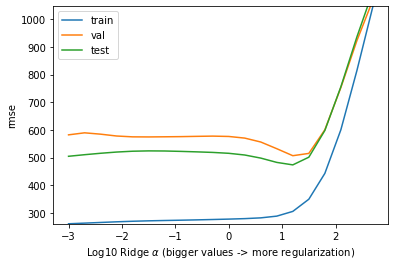

In [46]:
metric = 'rmse'

for dataset in ['train', 'val', 'test']:
    plt.plot(np.log10(all_results['ridge_alpha']), all_results['%s_%s' % (metric, dataset)], label=dataset)
plt.xlabel(r'Log10 Ridge $\alpha$ (bigger values -> more regularization)')
plt.ylim([all_results['%s_train' % metric].min() - 0.1, all_results['%s_train' % metric].max() + 0.1])
plt.ylabel("%s" % metric)
plt.legend()

15.848931924611044


{'rmse_train': 305.3446340539146,
 'mae_train': 194.08018915261582,
 'R^2_train': 0.966489462312578,
 'rmse_val': 506.8046911767647,
 'mae_val': 323.13953334663074,
 'R^2_val': 0.868057956944044,
 'rmse_test': 473.60057631576694,
 'mae_test': 298.66349601313505,
 'R^2_test': 0.8896206781632918}

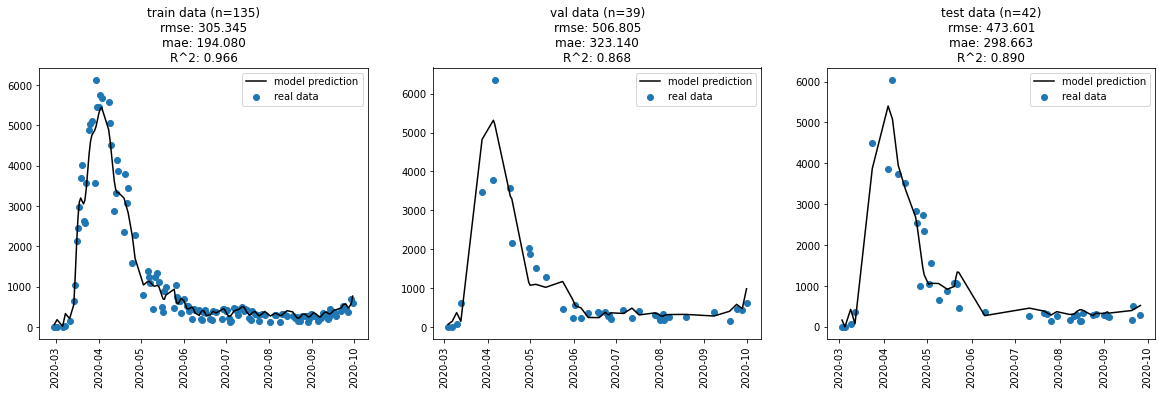

In [47]:
best_ridge_alpha = all_results.sort_values(by='rmse_val').iloc[0]['ridge_alpha']
print(best_ridge_alpha)


        
assess_with_validation_set(first_wave, model_hyperparameters={'model_type':'Ridge', 
                                                             'Ridge_formula':formula_to_use, 
                                                              'ridge_alpha':best_ridge_alpha}, 
                           make_plot=True)

# Homework

On the homework, you will be exploring how to use regularization to improve model fit in a very different prediction task: predicting whether someone stopped by police will carry a weapon. Rather than using a linear regression model, you will be using a logistic regression model (which, as we saw in the last lecture, is for binary variables - in this case, whether the person has a weapon). Still, the core ideas will be very similar. 

# Epilogue: if the world changes, models can fail very badly, even with regularization. 

We've seen how to use regularization to improve model generalization and reduce overfitting, and it is pretty much always a good idea to try this if you have high-dimensional data (ie, with a lot of features you're using to predict) and you care about good predictive performance. But there are limits to what this can do. If your test data is drawn from a completely different distribution than your train data, you may just be in trouble. 

For example, in the case of the pandemic, if you trained your predictive model in a rural area, and tried to apply it in a city, or if you trained it on the time period from before there was vaccination, and tried to apply it when there was vaccination, you could see it fail catastrophically, even with regularization. This phenomenon, known as "dataset shift", is a major challenge to making predictive models work in the real world, and it is a very active area of research. It also means that when you apply a predictive model, you should understand what data the model was trained on, and how that might differ from the data you're applying it to. 

As we'll discuss more later, dataset shift can have implications for fairness and equity as well. For example, because facial analysis algorithms were trained predominantly on light-skinned people, they have been found to have worse performance on [darker-skinned people](https://www.media.mit.edu/projects/gender-shades/overview/). Facial analysis algorithms are used in high-stakes applications, including policing, so these issues matter.

# Epilogue II: this is not how you would fit a real COVID model. 

We saw that many of our models could give predictions which were literally impossible - for example, negative numbers of cases, or numbers of cases which exceeded the whole population. Real-world COVID models try to avoid these problems in various ways. For example, while linear regression can predict negative numbers, other forms of regression, like Poisson or Negative Binomial regressions, cannot, and are often to used to model count data for this reason. 

Another problem with the model is that it just tries to learn an arbitrary function of time, and doesn't capture many of the actual things we know affect COVID case counts. For example, we might incorporate some aspect of weekly periodicity, to capture the fact that the number of reported cases fluctuates by weekday. We might use an SEIR model, as Serina Chang explained in her lecture, or incorporate external data like mobility which affects disease transmission. All of these approaches are ways of bringing in our actual real-world knowledge to improve our predictive performance and the interpretability of our modeling. 
